In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='monospace')

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1558 non-null   object 
 1   wins            1558 non-null   int64  
 2   kills           1558 non-null   int64  
 3   kdRatio         1558 non-null   float64
 4   killstreak      1558 non-null   int64  
 5   level           1558 non-null   int64  
 6   losses          1558 non-null   int64  
 7   prestige        1558 non-null   int64  
 8   hits            1558 non-null   int64  
 9   timePlayed      1558 non-null   int64  
 10  headshots       1558 non-null   int64  
 11  averageTime     1558 non-null   float64
 12  gamesPlayed     1558 non-null   int64  
 13  assists         1558 non-null   int64  
 14  misses          1558 non-null   int64  
 15  xp              1558 non-null   int64  
 16  scorePerMinute  1558 non-null   float64
 17  shots           1558 non-null   i

In [4]:
df['winRate']        = df['wins'] / (df['wins'] + df['losses'])
df['killsPerGame']   = df['kills'] / df['gamesPlayed']
df['deathsPerGame']  = df['deaths'] / df['gamesPlayed']
df['assistsPerGame'] = df['assists'] / df['gamesPlayed']
df['hitRate']        = df['hits'] / df['shots']
df['headshotRate']   = df['headshots'] / df['shots']
df['winRateAlt']     = df['winRate'] * np.log(df['gamesPlayed'])
df['kdRatioAlt']     = df['kdRatio'] * np.log(df['gamesPlayed'])
df.replace([np.nan, np.inf, -np.inf], 0, inplace=True)

## Preliminary Analysis

---

- How might we predict `kdRatioAlt`?
- How might we predict `winRateAlt`?

### Suggested Predictors

- `level`
- `prestige`
- `xp`
- `hitRate`
- `timePlayed`
- `averageTime`
- `gamesPlayed`
- `headshotRate`
- `assistsPerGame`

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [6]:
def model_evaluation(df, predictors, target, model_instance):
    df_train, df_test = train_test_split(df, test_size=0.2)
    model = model_instance.fit(df_train[predictors], df_train[[target]])
    
    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])
    r2_train, mse_test = r2_score(df_train[[target]], pred_train), mean_squared_error(df_test[[target]], pred_test)
    
    print(f'r2 (Train Set)\t{r2_train:.3f}')
    print(f'MSE (Test Set)\t{mse_test:.3f}')

    return r2_train, mse_test

In [7]:
def plot_correlation_heatmap(data, variables, cmap):
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    axes.set_title('Correlation Heatmap', fontsize=20)
    sns.heatmap(data=data[variables].corr(), annot=True, fmt='.2f', linewidth=1.5, ax=axes, cmap=cmap)

In [8]:
def model_evaluation_w_grid_search(df, predictors, target, model_instance, param_grid, cv):
    df_train, df_test = train_test_split(df, test_size=0.2)
    model = GridSearchCV(estimator=model_instance, param_grid=param_grid, cv=cv, scoring='r2')
    model.fit(df_train[predictors], df_train[[target]])
    
    print('<<- Grid Search Results (Best Parameters) ->>\n')
    for k, v in model.best_params_.items():
       print(f'{k:10}\t{v}')
    print()
    
    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])
    r2_train, mse_test = r2_score(df_train[[target]], pred_train), mean_squared_error(df_test[[target]], pred_test)
    
    print(f'r2 (Train Set)\t{r2_train:.3f}')
    print(f'MSE (Test Set)\t{mse_test:.3f}')

    return r2_train, mse_test

In [9]:
model_performance = {'kdRatioAlt': {}, 'winRateAlt': {}}

## Linear Regression

---

### **Target Variable**: `kdRatioAlt`

In [10]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'kdRatioAlt'

In [11]:
correlations = [np.corrcoef(df[pred], df[target])[0][1] for pred in predictors]

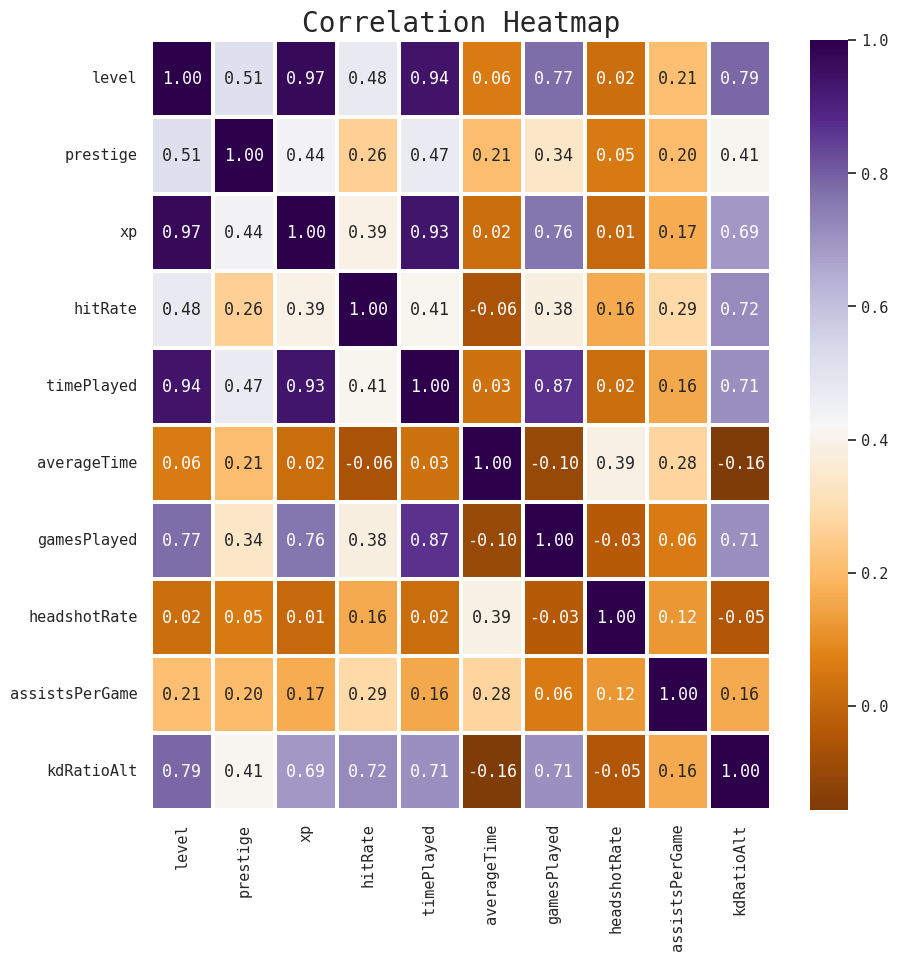

In [12]:
plot_correlation_heatmap(data=df, variables=predictors+[target], cmap='PuOr')

In [13]:
print('<<- Predictors Ranked ->>\n')
for corr, pred in sorted(zip(correlations, predictors)):
    print(f'{pred:10}\t{corr:+.3f}')

<<- Predictors Ranked ->>

averageTime	-0.156
headshotRate	-0.048
assistsPerGame	+0.161
prestige  	+0.411
xp        	+0.692
gamesPlayed	+0.710
timePlayed	+0.711
hitRate   	+0.718
level     	+0.786


In [14]:
predictors_top_3 = [i[1] for i in sorted(zip(correlations, predictors))[-3:]]
print(predictors_top_3)

['timePlayed', 'hitRate', 'level']


In [15]:
predictor_performance = {'predictor': [], 'MSE (Test Set)': []}

In [16]:
print('<<- Univariate Prediction ->>')
for pred in predictors:
    print(f'\n|> {pred}')
    _, mse = model_evaluation(df=df, predictors=[pred], target=target, model_instance=LinearRegression())
    predictor_performance['predictor'].append(pred)
    predictor_performance['MSE (Test Set)'].append(mse)

<<- Univariate Prediction ->>

|> level
r2 (Train Set)	0.629
MSE (Test Set)	2.676

|> prestige
r2 (Train Set)	0.168
MSE (Test Set)	5.296

|> xp
r2 (Train Set)	0.476
MSE (Test Set)	2.891

|> hitRate
r2 (Train Set)	0.503
MSE (Test Set)	2.467

|> timePlayed
r2 (Train Set)	0.509
MSE (Test Set)	3.413

|> averageTime
r2 (Train Set)	0.027
MSE (Test Set)	6.074

|> gamesPlayed
r2 (Train Set)	0.494
MSE (Test Set)	2.619

|> headshotRate
r2 (Train Set)	0.002
MSE (Test Set)	7.011

|> assistsPerGame
r2 (Train Set)	0.085
MSE (Test Set)	10.749


In [17]:
print('<<- Multivariate Prediction ->>')

print('\n|> All 9')
_, mse = model_evaluation(df=df, predictors=predictors, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('All 9')
predictor_performance['MSE (Test Set)'].append(mse)

print('\n|> Top 3')
_, mse = model_evaluation(df=df, predictors=predictors_top_3, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('Top 3')
predictor_performance['MSE (Test Set)'].append(mse)

<<- Multivariate Prediction ->>

|> All 9
r2 (Train Set)	0.874
MSE (Test Set)	1.370

|> Top 3
r2 (Train Set)	0.759
MSE (Test Set)	1.218


In [18]:
pairs = sorted((predictor_performance['MSE (Test Set)'][i],
                predictor_performance['predictor'][i]) for i in range(len(predictor_performance['predictor'])))
predictor_performance['predictor'] = [pair[1] for pair in pairs]
predictor_performance['MSE (Test Set)'] = [pair[0] for pair in pairs]

(0.0, 13.973212619042982)

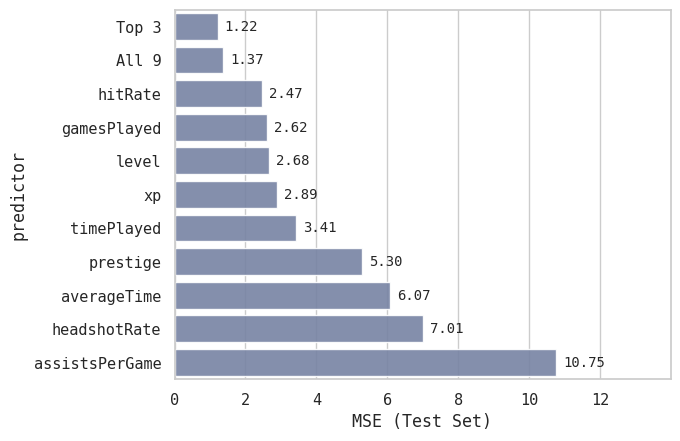

In [19]:
ax = sns.barplot(data=pd.DataFrame(predictor_performance),
                 x='MSE (Test Set)',
                 y='predictor',
                 orient='y',
                 color='#7080aa',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, predictor_performance['MSE (Test Set)'][-1] * 1.3)

In [20]:
model_performance[target]['LinearRegression'] = predictor_performance['MSE (Test Set)'][0]

### **Target Variable**: `winRateAlt`

In [21]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'winRateAlt'

In [22]:
correlations = [np.corrcoef(df[pred], df[target])[0][1] for pred in predictors]

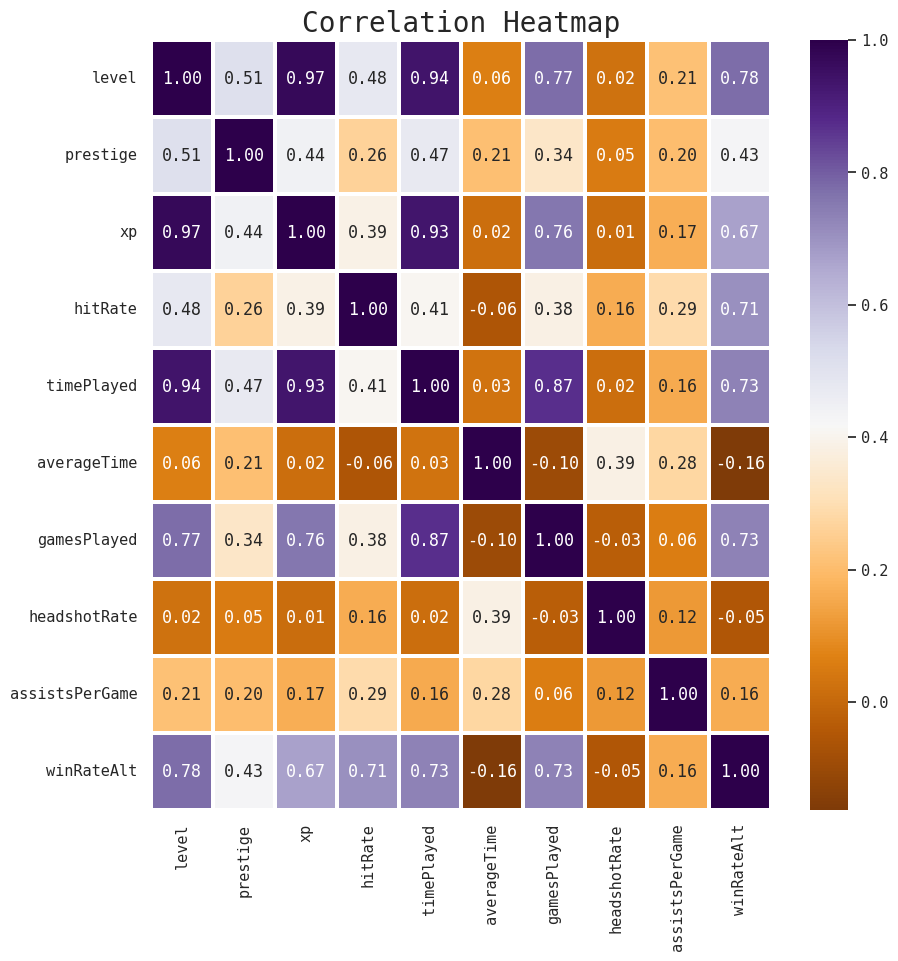

In [23]:
plot_correlation_heatmap(data=df, variables=predictors+[target], cmap='PuOr')

In [24]:
print('<<- Predictors Ranked ->>\n')
for corr, pred in sorted(zip(correlations, predictors)):
    print(f'{pred:10}\t{corr:+.3f}')

<<- Predictors Ranked ->>

averageTime	-0.163
headshotRate	-0.051
assistsPerGame	+0.160
prestige  	+0.430
xp        	+0.671
hitRate   	+0.707
gamesPlayed	+0.733
timePlayed	+0.734
level     	+0.777


In [25]:
predictors_top_3 = [i[1] for i in sorted(zip(correlations, predictors))[-3:]]
print(predictors_top_3)

['gamesPlayed', 'timePlayed', 'level']


In [26]:
predictor_performance = {'predictor': [], 'MSE (Test Set)': []}

In [27]:
print('<<- Univariate Prediction ->>')
for pred in predictors:
    print(f'\n|> {pred}')
    _, mse = model_evaluation(df=df, predictors=[pred], target=target, model_instance=LinearRegression())
    predictor_performance['predictor'].append(pred)
    predictor_performance['MSE (Test Set)'].append(mse)

<<- Univariate Prediction ->>

|> level
r2 (Train Set)	0.607
MSE (Test Set)	2.391

|> prestige
r2 (Train Set)	0.169
MSE (Test Set)	3.940

|> xp
r2 (Train Set)	0.445
MSE (Test Set)	2.967

|> hitRate
r2 (Train Set)	0.494
MSE (Test Set)	2.605

|> timePlayed
r2 (Train Set)	0.534
MSE (Test Set)	2.672

|> averageTime
r2 (Train Set)	0.027
MSE (Test Set)	5.536

|> gamesPlayed
r2 (Train Set)	0.526
MSE (Test Set)	2.382

|> headshotRate
r2 (Train Set)	0.003
MSE (Test Set)	6.233

|> assistsPerGame
r2 (Train Set)	0.042
MSE (Test Set)	5.821


In [28]:
print('<<- Multivariate Prediction ->>')

print('\n|> All 9')
_, mse = model_evaluation(df=df, predictors=predictors, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('All 9')
predictor_performance['MSE (Test Set)'].append(mse)

print('\n|> Top 3')
_, mse = model_evaluation(df=df, predictors=predictors_top_3, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('Top 3')
predictor_performance['MSE (Test Set)'].append(mse)

<<- Multivariate Prediction ->>

|> All 9
r2 (Train Set)	0.876
MSE (Test Set)	0.657

|> Top 3
r2 (Train Set)	0.672
MSE (Test Set)	1.804


In [29]:
pairs = sorted((predictor_performance['MSE (Test Set)'][i],
                predictor_performance['predictor'][i]) for i in range(len(predictor_performance['predictor'])))
predictor_performance['predictor'] = [pair[1] for pair in pairs]
predictor_performance['MSE (Test Set)'] = [pair[0] for pair in pairs]

(0.0, 8.10354116978892)

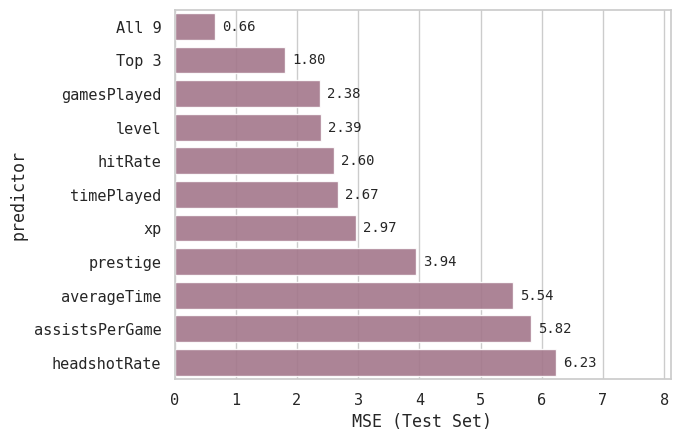

In [30]:
ax = sns.barplot(data=pd.DataFrame(predictor_performance),
                 x='MSE (Test Set)',
                 y='predictor',
                 orient='y',
                 color='#aa708a',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, predictor_performance['MSE (Test Set)'][-1] * 1.3)

In [31]:
model_performance[target]['LinearRegression'] = predictor_performance['MSE (Test Set)'][0]

## Other Models (W/ Grid Search)

---

> Because multivariate regression on all nine predictors has proven to be most effective, we will continue to use all nine predictors
> for our subsequent regression models.

### **Target Variable**: `kdRatioAlt`

In [32]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'kdRatioAlt'

In [33]:
param_grid = {
    'alpha':    [0.1, 1, 10, 100],
    'tol':      [1e-3, 1e-4, 1e-5, 1e-6],
    'max_iter': [1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=Lasso(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['Lasso'] = mse

<<- Grid Search Results (Best Parameters) ->>

alpha     	0.1
max_iter  	1000
tol       	1e-06

r2 (Train Set)	0.794
MSE (Test Set)	1.515


In [34]:
param_grid = {
    'C':        [1.0, 2.0, 3.0, 4.0, 5.0],
    'tol':      [1e-3, 1e-4, 1e-5],
    'max_iter': [-1, 1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVR(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['SVR'] = mse

<<- Grid Search Results (Best Parameters) ->>

C         	5.0
max_iter  	-1
tol       	0.0001

r2 (Train Set)	0.751
MSE (Test Set)	1.566


In [35]:
param_grid = {
    'n_neighbors': [5, 10, 15, 20, 25],
    'leaf_size':   [5, 15, 30, 45],
    'weights':     ['uniform', 'distance']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['KNeighborsRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

leaf_size 	5
n_neighbors	25
weights   	uniform

r2 (Train Set)	0.786
MSE (Test Set)	1.606


In [36]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth':    [None, 5, 10],
    'max_features': [1, 'sqrt', 'log2']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['RandomForestRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

max_depth 	None
max_features	sqrt
n_estimators	150

r2 (Train Set)	0.992
MSE (Test Set)	0.372


In [37]:
param_grid = {
    'learning_rate': [0.1, 1, 10],
    'n_estimators':  [100, 200],
    'max_depth':     [3, 5, 7]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['GradientBoostingRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

learning_rate	0.1
max_depth 	3
n_estimators	100

r2 (Train Set)	0.981
MSE (Test Set)	0.330


(0.0, 2.087374985801912)

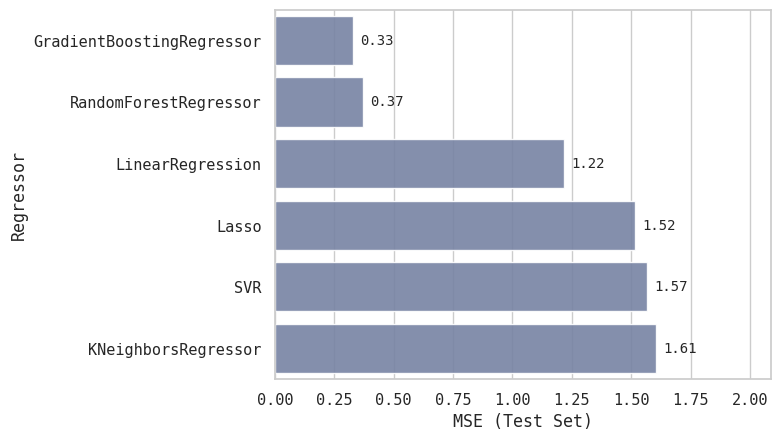

In [38]:
pairs = sorted((v, k) for k, v in model_performance[target].items())
result = {'Regressor': [pair[1] for pair in pairs], 'MSE (Test Set)': [pair[0] for pair in pairs]}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='MSE (Test Set)',
                 y='Regressor',
                 orient='y',
                 color='#7080aa',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, result['MSE (Test Set)'][-1] * 1.3)

### **Target Variable**: `winRateAlt`

In [39]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'winRateAlt'

In [40]:
param_grid = {
    'alpha':    [0.1, 1, 10, 100],
    'tol':      [1e-3, 1e-4, 1e-5, 1e-6],
    'max_iter': [1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=Lasso(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['Lasso'] = mse

<<- Grid Search Results (Best Parameters) ->>

alpha     	0.1
max_iter  	1000
tol       	1e-05

r2 (Train Set)	0.814
MSE (Test Set)	0.967


In [41]:
param_grid = {
    'C':        [1.0, 2.0, 3.0, 4.0, 5.0],
    'tol':      [1e-3, 1e-4, 1e-5],
    'max_iter': [-1, 1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVR(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['SVR'] = mse

<<- Grid Search Results (Best Parameters) ->>

C         	5.0
max_iter  	-1
tol       	1e-05

r2 (Train Set)	0.802
MSE (Test Set)	1.745


In [42]:
param_grid = {
    'n_neighbors': [5, 10, 15, 20, 25],
    'leaf_size':   [5, 15, 30, 45],
    'weights':     ['uniform', 'distance']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['KNeighborsRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

leaf_size 	5
n_neighbors	25
weights   	uniform

r2 (Train Set)	0.818
MSE (Test Set)	1.236


In [43]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth':    [None, 5, 10],
    'max_features': [1, 'sqrt', 'log2']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['RandomForestRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

max_depth 	None
max_features	log2
n_estimators	150

r2 (Train Set)	0.999
MSE (Test Set)	0.018


In [44]:
param_grid = {
    'learning_rate': [0.1, 1, 10],
    'n_estimators':  [100, 200],
    'max_depth':     [3, 5, 7]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['GradientBoostingRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

learning_rate	0.1
max_depth 	3
n_estimators	100

r2 (Train Set)	0.998
MSE (Test Set)	0.028


(0.0, 2.269012241948624)

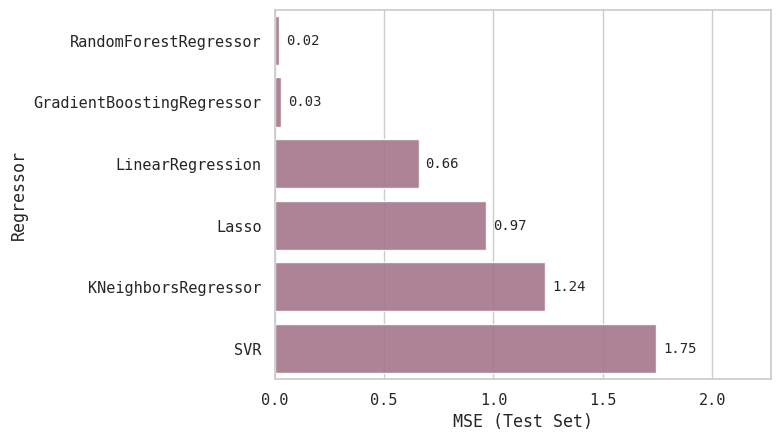

In [45]:
pairs = sorted((v, k) for k, v in model_performance[target].items())
result = {'Regressor': [pair[1] for pair in pairs], 'MSE (Test Set)': [pair[0] for pair in pairs]}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='MSE (Test Set)',
                 y='Regressor',
                 orient='y',
                 color='#aa708a',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, result['MSE (Test Set)'][-1] * 1.3)